In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import pandas as pd

In [48]:
def read_csv(path):
    return pd.read_csv(path)

all_letters = string.ascii_letters + " .,;'"
n_letter = len(all_letter)
dataframe = read_csv("gender.csv")
dataframe = dataframe[dataframe.gender != 3]
print(dataframe.head())

      name  gender  score
0        A       1    1.0
1     A.j.       1    1.0
2   A'isha       0    0.0
3  A'ishah       0    0.0
4  Aa'isha       0    0.0


In [49]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [50]:
gender_dict = {}
gender = [i for i in dataframe['gender'].unique()]

for idx, row in dataframe.iterrows():
    if row['gender'] not in gender_dict.keys():
        gender_dict[row['gender']] = []
    gender_dict[row['gender']].append(unicodeToAscii(row['name']))

n_category = len(gender)

In [51]:
print(gender_dict[1][:10])

['A', 'A.j.', 'Aaban', 'Aabid', 'Aabraham', 'Aadam', 'Aadan', 'Aadarsh', 'Aaden', 'Aadesh']


In [52]:
def letterToIndex(letter):
    return all_letters.index(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1,n_letter)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def nameToTensor(name):
    tensor = torch.zeros( len(name), 1, n_letter )
    for i in range(len(name)):
        tensor[i][0][letterToIndex(name[i])] = 1
    return tensor

print(letterToTensor('P'))
print(nameToTensor('Piyush').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([6, 1, 57])


In [53]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size+hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input,hidden),dim=1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letter, n_hidden, n_category)

In [54]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [55]:
input = nameToTensor('Piyush')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-0.6180, -0.7744]], grad_fn=<LogSoftmaxBackward>)


In [56]:
def categoryFromOutput(output):
    top_k, top_i = output.topk(1)
    category_i = top_i[0].item()
    return gender[category_i], category_i

print(categoryFromOutput(output))

(1, 0)


In [57]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

def randomTrainingExample():
    category = randomChoice(gender)
    name = randomChoice(gender_dict[category])
    category_tensor = torch.tensor([gender.index(category)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    return category, name, category_tensor, name_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = 1 / line = Marchant
category = 0 / line = Roshanne
category = 1 / line = Chaudhary
category = 0 / line = Libbyjane
category = 1 / line = Kabeer
category = 0 / line = Dalayjah
category = 1 / line = Marquarious
category = 0 / line = Jenisse
category = 0 / line = Gerrica
category = 0 / line = Illyana


In [58]:
criterion = nn.NLLLoss()

In [59]:
learning_rate = 0.005

def train(category_tensor, name_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    
    return output, loss.item()

In [60]:
import time
import math

n_iter = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

rnn = RNN(n_letter, n_hidden, n_category)

def guessToWord(guess):
    if guess == 1:
        return "Male"
    elif guess == 0:
        return "Female"
    else:
        return "Unisexual"

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iter+1):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    output, loss = train(category_tensor, name_tensor)
    
    current_loss += loss
    
    if iter%print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        gen_cat = guessToWord(guess)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iter * 100, timeSince(start), loss, name, guess, correct))
    
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 12s) 1.0608 Murial / 1 ✗ (0)
10000 10% (0m 20s) 0.2580 Silender / 1 ✓
15000 15% (0m 30s) 0.9670 Delacy / 1 ✗ (0)
20000 20% (0m 42s) 0.0718 Gumaro / 1 ✓
25000 25% (0m 53s) 0.1418 Muhammadahmad / 1 ✓
30000 30% (1m 4s) 0.0892 Reston / 1 ✓
35000 35% (1m 14s) 0.8522 Cardyn / 1 ✗ (0)
40000 40% (1m 25s) 1.7395 Garnet / 1 ✗ (0)
45000 45% (1m 37s) 0.8859 Ayled / 1 ✗ (0)
50000 50% (1m 44s) 0.0769 Katresa / 0 ✓
55000 55% (1m 51s) 0.0335 Markaya / 0 ✓
60000 60% (2m 0s) 0.1870 Finbar / 1 ✓
65000 65% (2m 7s) 0.1293 Caz / 1 ✓
70000 70% (2m 16s) 0.0103 Khadeeja / 0 ✓
75000 75% (2m 23s) 0.1084 Kwan / 1 ✓
80000 80% (2m 30s) 0.1042 Jamall / 1 ✓
85000 85% (2m 37s) 0.2661 Celio / 1 ✓
90000 90% (2m 44s) 0.3459 Maewyn / 0 ✓
95000 95% (2m 51s) 0.5581 Summerlee / 0 ✓
100000 100% (2m 58s) 0.3055 Jubaira / 0 ✓


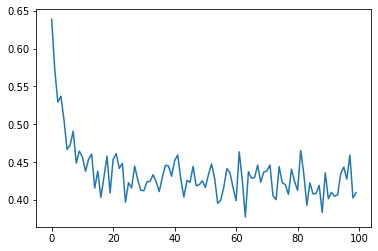

In [61]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


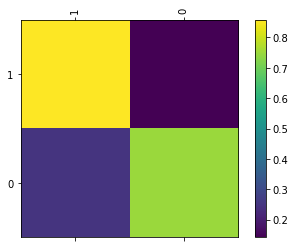

In [62]:
confusion = torch.zeros(n_category, n_category)
n_confusion = 5000

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    
    guess, guess_i = categoryFromOutput(output)
    category_i = gender.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_category):
    confusion[i] = confusion[i]/confusion[i].sum()
    
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + gender, rotation=90)
ax.set_yticklabels([''] + gender)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [70]:
def predict(input_line, n_predictions=2):
    print('\n> %s' % input_line)
    
    with torch.no_grad():
        output = evaluate(nameToTensor(input_line))
        
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, guessToWord(gender[category_index])))
            predictions.append([value, gender[category_index]])

predict('Nandini')
predict('Himanshi')
predict('Himanshu')


> Nandini
(-0.14) Female
(-2.04) Male

> Himanshi
(-0.64) Female
(-0.75) Male

> Himanshu
(-0.20) Male
(-1.69) Female
